# Getting started with `sidewinder`

In [18]:
import os, sys
sys.path.append(os.pardir)  # Needed for sidewinder import before we install it

import matplotlib.pyplot as plt

from sidewinder.synthetic import synthetic_arterial_pressure_data
from sidewinder.waveforms import Waveforms
from sidewinder.features.waveform import find_troughs

## Load some waveform data

We generate some synthetic arterial blood pressure data for demonstration purposes.

In [19]:
data = synthetic_arterial_pressure_data(
    systolic_pressure=120,
    diastolic_pressure=80,
    heart_rate=70,
    n_beats_target=5.5,
    hertz=200
)

data.head()

,time,pressure
0,0.000,80.036898
1,0.005,80.171417
2,0.010,80.491293
3,0.015,81.096162
4,0.020,82.081690


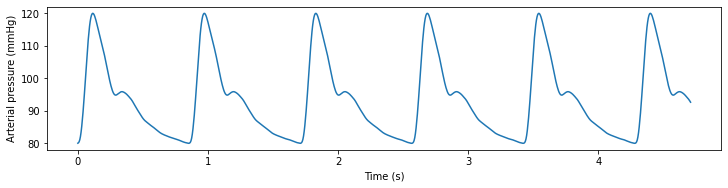

In [20]:
fig, ax = plt.subplots(figsize=(10, 2.5), constrained_layout=True)
ax.plot(data.time, data.pressure)
ax.set(xlabel='Time (s)', ylabel='Arterial pressure (mmHg)')
plt.show()

## Load the data into `sidewinder`

In [21]:
wf = Waveforms(data)

## Find troughs in a waveform

For example, we could use the troughs to split our arterial blood pressure data into separate heartbeats.

In [22]:
wf = find_troughs(wf, name='pressure')

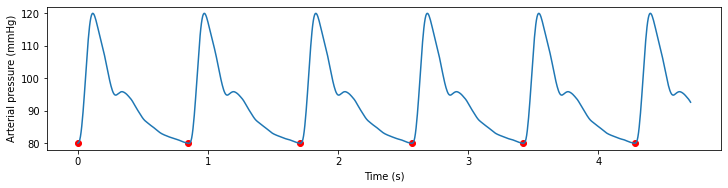

In [23]:
fig, ax = plt.subplots(figsize=(10, 2.5), constrained_layout=True)
ax.plot(data.time, data.pressure)
ax.scatter(
    data.time[wf.features['pressure']['troughs']],
    data.pressure[wf.features['pressure']['troughs']],
    color='red',
)
ax.set(xlabel='Time (s)', ylabel='Arterial pressure (mmHg)')
plt.show()